# Potencial $V(x) = x^4$ — Numerov vs Diferencias Finitas

Se resuelve la ecuación de Schrödinger estacionaria en unidades naturales ($\hbar^2/2m = 1$):

$$-\psi'' + x^4\,\psi = E\,\psi$$

en el dominio $[-6, 6]$ con condiciones de frontera $\psi(\pm 6) = 0$.

Valores de referencia del oscilador cuártico (dominio infinito):
$$E_n^{\text{ref}} \approx 1.060,\; 3.800,\; 7.456,\; 11.645,\; 16.262,\; 21.238 \dots$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import subprocess, os

_nb_path = globals().get("__vsc_ipynb_file__", None)
if _nb_path:
    WORKDIR = os.path.dirname(os.path.abspath(_nb_path))
else:
    WORKDIR = os.path.abspath("2.EDOs/taller-numerov2")

os.chdir(WORKDIR)
print("Directorio de trabajo:", os.getcwd())

Directorio de trabajo: /home/isabel/MFC/2.EDOs/taller-numerov2


## 1. Diferencias Finitas (Fortran)

Se discretiza el Hamiltoniano en una malla de $N$ puntos:

$$H_{ii} = \frac{2}{h^2} + x_i^4, \qquad H_{i,i\pm 1} = -\frac{1}{h^2}$$

Diagonalizado con el algoritmo de Householder–QL (`diagotri`).

In [2]:
diagotri_src = """\
SUBROUTINE diagotri(d,e,N,z,vectors)
  IMPLICIT NONE
  INTEGER,INTENT(IN)::N
  REAL(8),INTENT(INOUT)::d(N),e(N),z(N,N)
  LOGICAL,INTENT(IN)::vectors
  integer::i,iter,l,m
  real(8)::b,c,dd,f,g,p,r,s,pythag,ff(N)
  e(:)=eoshift(e(:),1)
  do l=1,N
     iter=0
     ITERATE: do
        do m=l,N-1
           dd=abs(d(m))+abs(d(m+1))
           if(abs(e(m))+dd.eq.dd)EXIT
        enddo
        if(m.eq.l) EXIT ITERATE
        if(iter.eq.30)then; write(6,*)'no converge'; stop; end if
        iter=iter+1
        g=(d(l+1)-d(l))/(2.d0*e(l)); r=pythag(g,1.d0)
        g=d(m)-d(l)+e(l)/(g+sign(r,g))
        s=1.d0; c=1.d0; p=0.d0
        do i=m-1,l,-1
           f=s*e(i); b=c*e(i); r=pythag(f,g); e(i+1)=r
           if(r.eq.0.d0)then; d(i+1)=d(i+1)-p; e(m)=0.d0; CYCLE ITERATE; endif
           s=f/r; c=g/r; g=d(i+1)-p; r=(d(i)-g)*s+2.d0*c*b
           p=s*r; d(i+1)=g+p; g=c*r-b
           if(vectors)then
              ff(:)=z(:,i+1); z(:,i+1)=s*z(:,i)+c*ff(:); z(:,i)=c*z(:,i)-s*ff(:)
           end if
        end do
        d(l)=d(l)-p; e(l)=g; e(m)=0.d0
     enddo ITERATE
  enddo
END SUBROUTINE diagotri
REAL(8) FUNCTION pythag(a,b)
  REAL(8)::a,b,absa,absb
  absa=abs(a); absb=abs(b)
  if(absa.gt.absb)then; pythag=absa*sqrt(1.+(absb/absa)**2)
  else
     if(absb.eq.0.d0)then; pythag=0.d0
     else; pythag=absb*sqrt(1.d0+(absa/absb)**2); end if
  end if
END FUNCTION pythag
"""

fd_src = """\
PROGRAM PotX4
  implicit none
  integer::i,j,N,Nf
  real(8),allocatable::A(:,:),d(:),e(:),tem(:)
  real(8)::h,xi,h_2
  N=50; Nf=1000
  do while(N.le.Nf)
     h=12.d0/N; h_2=1.d0/h**2
     allocate(A(N,N),d(N),e(N),tem(N))
     A=0.d0; d=0.d0; e=0.d0
     do i=1,N
        xi=-6.d0+i*h
        d(i)=2.d0*h_2+xi**4
        e(i)=-h_2
        A(i,i)=1.d0
     end do
     call diagotri(d,e,N,A,.true.)
     do i=1,N
        do j=i+1,N
           if(d(j).lt.d(i))then
              xi=d(i); d(i)=d(j); d(j)=xi
              tem(:)=A(:,i); A(:,i)=A(:,j); A(:,j)=tem(:)
           end if
        end do
     end do
     write(6,"(i5,6(2x,F12.6))")N,d(1:6)
     if(N.ge.Nf/2)then
        open(unit=1,file="data_x4_fd")
        write(1,"('# N=',i5,2x,6(F14.8,1x))")N,d(1:6)
        tem=0.d0
        do i=1,N; tem(:)=tem(:)+A(i,:)**2; end do
        tem=h*tem
        do i=1,N
           xi=-6.d0+i*h
           write(1,"(7(F14.8,1x))")xi,A(i,1:6)**2/tem(i)
        enddo
        close(1)
     end if
     deallocate(A,d,e,tem)
     N=2*N
  end do
END PROGRAM PotX4
"""

with open("diagotri.f90", "w") as f: f.write(diagotri_src)
with open("pot_x4_fd.f90", "w") as f: f.write(fd_src)

r = subprocess.run("gfortran pot_x4_fd.f90 diagotri.f90 -o pot_x4_fd -O2",
                   shell=True, capture_output=True, text=True)
print("✓ Compilado" if r.returncode == 0 else f"✗ Error:\n{r.stderr}")

✓ Compilado


In [3]:
r = subprocess.run("./pot_x4_fd", shell=True, capture_output=True, text=True)
print(r.stdout)

with open("data_x4_fd") as f:
    header = f.readline()
E_fd = np.array([float(v) for v in header.strip().lstrip("#").split()[2:8]])

data_fd = np.loadtxt("data_x4_fd")
x_fd    = data_fd[:, 0]
psi2_fd = data_fd[:, 1:7]

print("Energías FD:", np.round(E_fd, 6))

   50      1.053547      3.750637      7.289421     11.253121     15.507609     19.957161
  100      1.058660      3.787445      7.414319     11.547537     16.075170     20.922363
  200      1.059937      3.796618      7.445365     11.620485     16.215272     21.159614
  400      1.060256      3.798909      7.453115     11.638683     16.250194     21.218698
  800      1.060335      3.799482      7.455052     11.643230     16.258919     21.233455

Energías FD: [ 1.060336  3.799482  7.455052 11.64323  16.258919 21.233455]


## 2. Método de Numerov (Python)

La ecuación se reescribe como $\psi'' + k^2(x)\,\psi = 0$ con $k^2(x) = E - x^4$.

$$\psi_{i+1} = \frac{2\!\left(1 - \tfrac{5}{12}h^2 k^2_i\right)\psi_i \;-\; \left(1 + \tfrac{1}{12}h^2 k^2_{i-1}\right)\psi_{i-1}}{1 + \tfrac{1}{12}h^2 k^2_{i+1}}$$

Los autovalores se localizan barriendo $E$ y refinando con **bisección**.

In [19]:
_trapz = getattr(np, "trapezoid", None) or np.trapz

def numerov_shoot(E, x, V):
    """Devuelve ψ(x[-1]) para bisección, usando solo 2 escalares (sin overflow)."""
    h = x[1] - x[0]; k2 = E - V; c = h**2 / 12.0
    p0, p1 = 0.0, 1e-6
    for i in range(1, len(x) - 1):
        p2 = (2*(1 - 5*c*k2[i])*p1 - (1 + c*k2[i-1])*p0) / (1 + c*k2[i+1])
        p0, p1 = p1, p2
        if abs(p1) > 1e10:   # rescalar solo los dos valores de trabajo
            p0 /= 1e10; p1 /= 1e10
    return p1

def numerov_wf(E, x, V):
    """Devuelve |ψ|² normalizado, anulando la región prohibida para evitar artefactos."""
    h = x[1] - x[0]; k2 = E - V; c = h**2 / 12.0
    n = len(x)
    psi = np.zeros(n)
    psi[1] = 1e-6
    p0, p1 = 0.0, 1e-6
    for i in range(1, n - 1):
        p2 = (2*(1 - 5*c*k2[i])*p1 - (1 + c*k2[i-1])*p0) / (1 + c*k2[i+1])
        p0, p1 = p1, p2
        if abs(p1) > 1e10:
            p0 /= 1e10; p1 /= 1e10
        psi[i+1] = p1
    # Anular región clásicamente prohibida profunda (artefacto numérico allí)
    psi[V > 5 * max(E, 0.1)] = 0.0
    norm = _trapz(psi**2, x)
    if norm > 0:
        psi /= np.sqrt(norm)
    return psi

def biseccion(E1, E2, x, V, tol=1e-10):
    f1 = numerov_shoot(E1, x, V)
    while abs(E2 - E1) > tol:
        Em = 0.5*(E1 + E2)
        fm = numerov_shoot(Em, x, V)
        if fm * f1 < 0:
            E2 = Em
        else:
            E1, f1 = Em, fm
    return 0.5*(E1 + E2)

x_num = np.linspace(-6, 6, 4000)
V_num = x_num**4

E_scan  = np.linspace(0.0, 25.0, 10000)
psi_end = np.array([numerov_shoot(E, x_num, V_num) for E in E_scan])

E_num_vals = []
psi2_num   = []

for i in range(len(E_scan) - 1):
    if psi_end[i] * psi_end[i+1] < 0:
        E_eig = biseccion(E_scan[i], E_scan[i+1], x_num, V_num)
        psi   = numerov_wf(E_eig, x_num, V_num)
        E_num_vals.append(E_eig)
        psi2_num.append(psi**2)
        if len(E_num_vals) == 6:
            break

E_num_vals = np.array(E_num_vals)
psi2_num   = np.array(psi2_num)

print("Energías Numerov:", np.round(E_num_vals, 6))
print("Energías FD:     ", np.round(E_fd[:len(E_num_vals)], 6))

Energías Numerov: [ 1.060362  3.799673  7.455698 11.644746 16.261826 21.238373]
Energías FD:      [ 1.060336  3.799482  7.455052 11.64323  16.258919 21.233455]


## 3. Gráfica interactiva — FD vs Numerov

In [20]:
def graficar(n):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(x_fd,  psi2_fd[:, n], color="royalblue",  lw=2,
             label=f"|ψ|² FD  (E = {E_fd[n]:.5f})")
    ax1.plot(x_num, psi2_num[n],   color="darkorange", lw=2, ls="--",
             label=f"|ψ|² Numerov  (E = {E_num_vals[n]:.5f})")
    ax1.set_xlabel("x", fontsize=12)
    ax1.set_ylabel(r"$|\psi_n(x)|^2$", fontsize=12)
    ax1.set_xlim(-6.5, 6.5)
    ax1.set_ylim(bottom=0)
    ax1.grid(True, alpha=0.3)

    x_v = np.linspace(-6, 6, 500)
    ax2.plot(x_v, x_v**4, color="gray", lw=1.5, alpha=0.5, label=r"$V(x)=x^4$")
    ax2.axhline(E_fd[n],       color="royalblue", ls="--", lw=1.2,
                label=f"E FD = {E_fd[n]:.5f}")
    ax2.axhline(E_num_vals[n], color="darkorange", ls=":",  lw=1.8,
                label=f"E Numerov = {E_num_vals[n]:.5f}")
    ax2.set_ylabel(r"$V(x)$  /  Energía", color="gray", fontsize=10)
    ax2.tick_params(axis="y", labelcolor="gray")
    ax2.set_ylim(-1, max(E_fd[n], E_num_vals[n]) * 1.6 + 1)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, fontsize=9, loc="upper center")

    plt.title(f"$V(x)=x^4$ — nivel $n={n}$   |   FD vs Numerov", fontsize=12)
    plt.tight_layout()
    plt.show()

N_lev = min(len(E_num_vals), len(E_fd), 6)
slider = widgets.IntSlider(value=0, min=0, max=N_lev - 1, step=1,
                           description="Nivel n:", continuous_update=False,
                           style={"description_width": "80px"},
                           layout=widgets.Layout(width="380px"))
display(widgets.interactive(graficar, n=slider))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Nivel n:', layout=Layout(width=…

## 4. Tabla comparativa de energías

In [25]:
# Valores de referencia del oscilador cuártico -ψ'' + x⁴ψ = Eψ (dominio infinito)
E_ref = np.array([1.060362, 3.799673, 7.455698, 11.644745, 16.261826, 21.238268])

N_lev = min(len(E_num_vals), len(E_fd), 6)

print(f"{'n':>3}  {'FD (Fortran)':>15}  {'Numerov (Python)':>18}  "
      f"{'Ref. (exacto)':>14}  {'Δ FD':>10}  {'Δ Numerov':>10}")
print("─" * 80)
for n in range(N_lev):
    dfd  = abs(E_fd[n]       - E_ref[n])
    dnum = abs(E_num_vals[n] - E_ref[n])
    print(f"{n:>3}  {E_fd[n]:>15.6f}  {E_num_vals[n]:>18.6f}  "
          f"{E_ref[n]:>14.6f}  {dfd:>10.2e}  {dnum:>10.2e}")

  n     FD (Fortran)    Numerov (Python)   Ref. (exacto)        Δ FD   Δ Numerov
────────────────────────────────────────────────────────────────────────────────
  0         1.060336            1.060362        1.060362    2.65e-05    9.05e-08
  1         3.799482            3.799673        3.799673    1.91e-04    2.98e-08
  2         7.455052            7.455698        7.455698    6.46e-04    6.21e-08
  3        11.643230           11.644746       11.644745    1.51e-03    5.11e-07
  4        16.258919           16.261826       16.261826    2.91e-03    1.80e-08
  5        21.233455           21.238373       21.238268    4.81e-03    1.05e-04


## 5. Espectro de energías

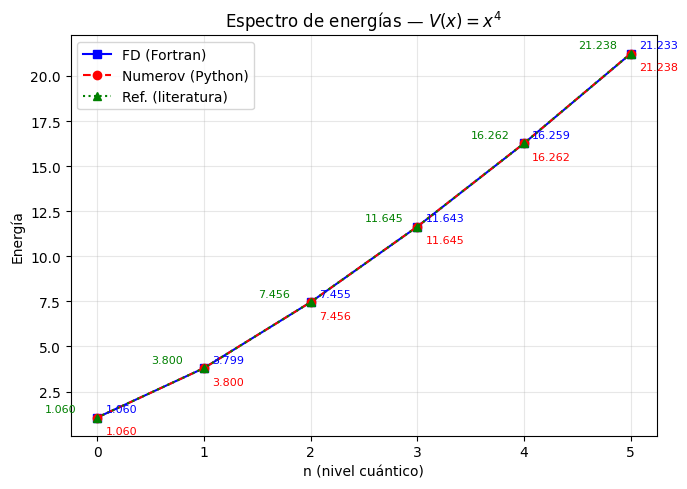

In [26]:
ns = np.arange(N_lev)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(ns, E_fd[:N_lev],       'bs-', label='FD (Fortran)')
ax.plot(ns, E_num_vals[:N_lev], 'ro--', label='Numerov (Python)')
ax.plot(ns, E_ref[:N_lev],      'g^:', label='Ref. (literatura)')

for n in range(N_lev):
    ax.annotate(f'{E_fd[n]:.3f}',       (n, E_fd[n]),       textcoords='offset points', xytext=(6,  4), fontsize=8, color='b')
    ax.annotate(f'{E_num_vals[n]:.3f}', (n, E_num_vals[n]), textcoords='offset points', xytext=(6, -12), fontsize=8, color='r')
    ax.annotate(f'{E_ref[n]:.3f}',      (n, E_ref[n]),      textcoords='offset points', xytext=(-38, 4), fontsize=8, color='g')

ax.set_xlabel('n (nivel cuántico)')
ax.set_ylabel('Energía')
ax.set_title(r'Espectro de energías — $V(x)=x^4$')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Error respecto a valores de referencia

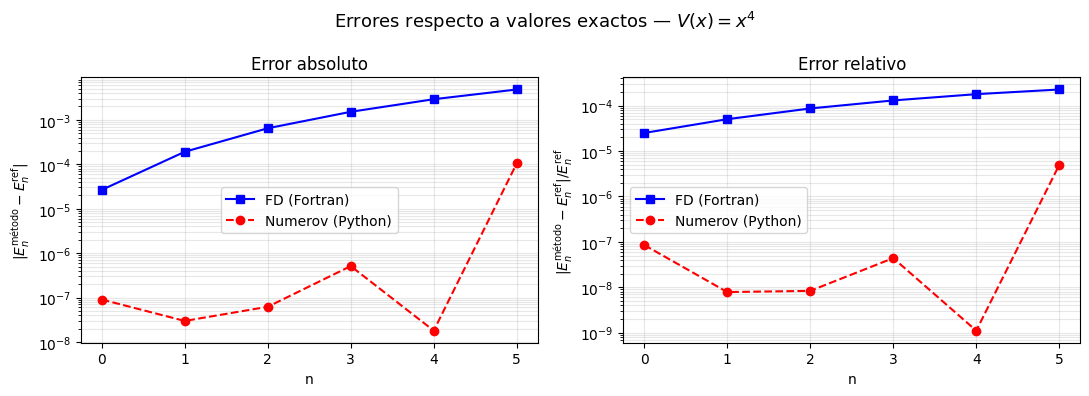

In [27]:
err_fd  = np.abs(E_fd[:N_lev]       - E_ref[:N_lev])
err_num = np.abs(E_num_vals[:N_lev] - E_ref[:N_lev])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# Error absoluto
ax1.semilogy(ns, err_fd,  'bs-',  label='FD (Fortran)')
ax1.semilogy(ns, err_num, 'ro--', label='Numerov (Python)')
ax1.set_xlabel('n')
ax1.set_ylabel(r'$|E_n^{\rm método} - E_n^{\rm ref}|$')
ax1.set_title('Error absoluto')
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Error relativo
ax2.semilogy(ns, err_fd  / E_ref[:N_lev], 'bs-',  label='FD (Fortran)')
ax2.semilogy(ns, err_num / E_ref[:N_lev], 'ro--', label='Numerov (Python)')
ax2.set_xlabel('n')
ax2.set_ylabel(r'$|E_n^{\rm método} - E_n^{\rm ref}| / E_n^{\rm ref}$')
ax2.set_title('Error relativo')
ax2.legend()
ax2.grid(True, which='both', alpha=0.3)

fig.suptitle(r'Errores respecto a valores exactos — $V(x)=x^4$', fontsize=13)
plt.tight_layout()
plt.show()

## 5. Tiempos de ejecución — FD vs Numerov

Método                           Mediana (ms)   Desv. std (ms)  Notas
────────────────────────────────────────────────────────────────────────────────
FD Fortran  (N = 50 → 1 000)          2346.17           165.65  Fortran -O2, barrido completo
Numerov Python  (4 000 pts)          74872.67          3295.12  Python puro, 10 000 energías

Numerov es 31.9× más lento que FD  (mediana de 3 ejecuciones)


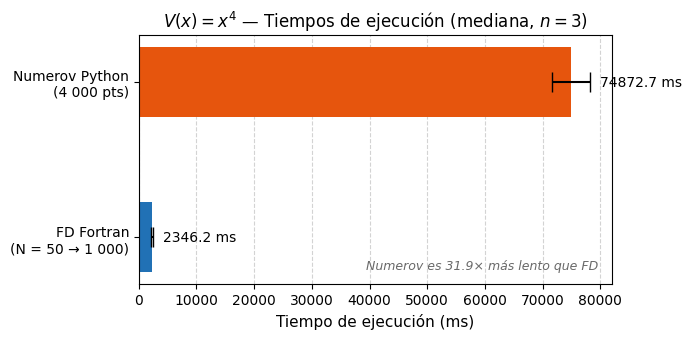

In [28]:
import time

N_rep = 3  # repeticiones para mediana robusta

# ── 1. FD Fortran (barrido N = 50 → 1000) ────────────────────────────────────
t_fd_runs = []
for _ in range(N_rep):
    t0 = time.perf_counter()
    subprocess.run("./pot_x4_fd", shell=True, capture_output=True)
    t_fd_runs.append(time.perf_counter() - t0)

t_fd_med = np.median(t_fd_runs) * 1e3   # ms
t_fd_std = np.std(t_fd_runs)    * 1e3

# ── 2. Numerov Python (barrido E + bisección, 4000 pts) ───────────────────────
def _run_numerov():
    pe = np.array([numerov_shoot(E, x_num, V_num) for E in E_scan])
    found = 0
    for i in range(len(pe) - 1):
        if pe[i] * pe[i + 1] < 0:
            biseccion(E_scan[i], E_scan[i + 1], x_num, V_num)
            found += 1
            if found == 6:
                break

t_num_runs = []
for _ in range(N_rep):
    t0 = time.perf_counter()
    _run_numerov()
    t_num_runs.append(time.perf_counter() - t0)

t_num_med = np.median(t_num_runs) * 1e3
t_num_std = np.std(t_num_runs)    * 1e3

# ── Tabla ─────────────────────────────────────────────────────────────────────
factor = t_num_med / t_fd_med
cmp_str = f"Numerov es {factor:.1f}× {'más lento' if factor > 1 else 'más rápido'} que FD"

print(f"{'Método':<30} {'Mediana (ms)':>14} {'Desv. std (ms)':>16}  Notas")
print("─" * 80)
print(f"{'FD Fortran  (N = 50 → 1 000)':<30} {t_fd_med:>14.2f} {t_fd_std:>16.2f}  Fortran -O2, barrido completo")
print(f"{'Numerov Python  (4 000 pts)':<30} {t_num_med:>14.2f} {t_num_std:>16.2f}  Python puro, 10 000 energías")
print(f"\n{cmp_str}  (mediana de {N_rep} ejecuciones)")

# ── Gráfica ───────────────────────────────────────────────────────────────────
labels     = ["FD Fortran\n(N = 50 → 1 000)", "Numerov Python\n(4 000 pts)"]
t_meds_arr = [t_fd_med, t_num_med]
t_stds_arr = [t_fd_std, t_num_std]
colors     = ["#2171b5", "#e6550d"]

fig, ax = plt.subplots(figsize=(7, 3.5))
bars = ax.barh(labels, t_meds_arr, xerr=t_stds_arr, color=colors, height=0.45,
               error_kw=dict(ecolor="black", lw=1.5, capsize=7), zorder=2)
ax.set_xlabel("Tiempo de ejecución (ms)", fontsize=11)
ax.set_title(r"$V(x) = x^4$ — Tiempos de ejecución (mediana, $n=" + str(N_rep) + r"$)",
             fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.55, zorder=1)

offset = max(t_stds_arr) * 0.3 + max(t_meds_arr) * 0.01
for bar, t, s in zip(bars, t_meds_arr, t_stds_arr):
    ax.text(t + s + offset, bar.get_y() + bar.get_height() / 2,
            f"{t:.1f} ms", va="center", fontsize=10)

ax.annotate(cmp_str, xy=(0.97, 0.06), xycoords="axes fraction",
            ha="right", fontsize=9, color="dimgray", style="italic")
ax.set_xlim(left=0)
plt.tight_layout()
plt.show()
